# A machine learning-based job forecasting and trend analysis system to predict future job markets using historical data.

## CONNECT DRIVE

In [ ]:
from google.colab import drive

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


### IMPORT LIBRARY READ DATASET

In [ ]:
!pip install tensorflow keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.8 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Bidirectional, Dense, Dropout
from kerastuner.tuners import RandomSearch
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

<ipython-input-7-8d49184c1d1b>:9: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch


Read dataset

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/datn/job_postings_dataset.csv')

In [ ]:
data.head(10)

,id,time,city,job,number_employees,major,level
0,1,1712094946000,Hà Nội,NodeJs,1,Công nghệ thông tin,intern
1,2,1698831347000,Đà Nẵng,Java Developer,2,Công nghệ thông tin,middle
2,3,1678989567000,Hà Nội,Python Developer,1,Công nghệ thông tin,senior
3,4,1692398292000,Hà Nội,DevOps Engineer,1,Công nghệ thông tin,junior
4,5,1682488366000,Hà Nội,Python Developer,2,Công nghệ thông tin,junior
5,6,1683205582000,Đà Nẵng,Backend Developer,1,Công nghệ thông tin,fresher
6,7,1697974575000,Hồ Chí Minh,Data Scientist,2,Công nghệ thông tin,middle
7,8,1713148265000,Hà Nội,NodeJs,2,Công nghệ thông tin,fresher
8,9,1679237250000,Hà Nội,Java Developer,2,Công nghệ thông tin,junior
9,10,1674237067000,Đà Nẵng,Python Developer,1,Công nghệ thông tin,junior


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   id                10000 non-null  int64 
 1   time              10000 non-null  int64 
 2   city              10000 non-null  object
 3   job               10000 non-null  object
 4   number_employees  10000 non-null  int64 
 5   major             10000 non-null  object
 6   level             10000 non-null  object
dtypes: int64(3), object(4)
memory usage: 547.0+ KB


In [ ]:
# Chuyển đổi cột 'time' từ Unix timestamp sang datetime
data['time'] = pd.to_datetime(data['time'], unit='ms')

# Thêm cột 'month' để tổng hợp theo tháng
data['month'] = data['time'].dt.to_period('M')

# Tổng hợp dữ liệu theo 'job', 'city', 'month'
aggregated_data = data.groupby(['job', 'city', 'month']).size().reset_index(name='job_postings_count')

# Kiểm tra dữ liệu sau khi tổng hợp
print(aggregated_data.head())

                 job    city    month  job_postings_count
0  Backend Developer  Hà Nội  2023-01                  25
1  Backend Developer  Hà Nội  2023-02                  27
2  Backend Developer  Hà Nội  2023-03                  29
3  Backend Developer  Hà Nội  2023-04                  16
4  Backend Developer  Hà Nội  2023-05                  26


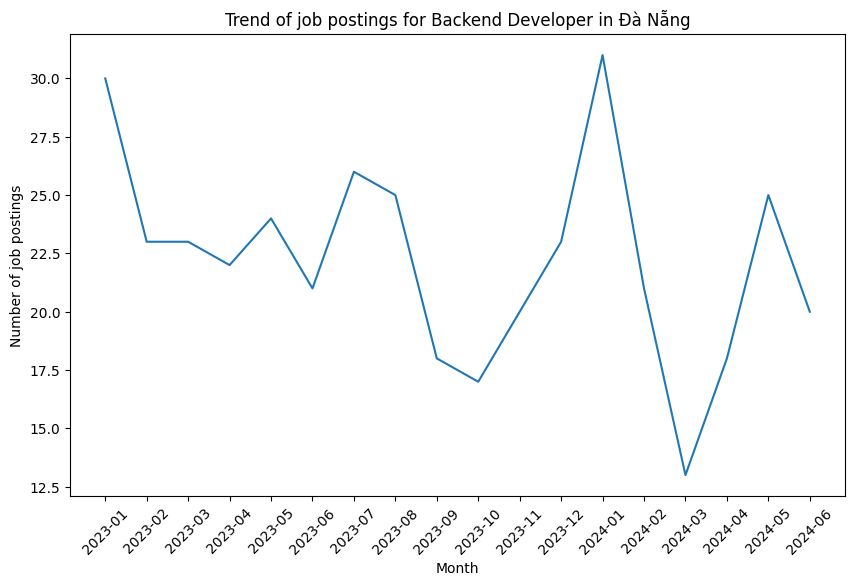

In [ ]:
# Vẽ biểu đồ số lượng tin tuyển dụng theo thời gian cho một số job cụ thể
def plot_job_trend(job, city):
    job_data = aggregated_data[(aggregated_data['job'] == job) & (aggregated_data['city'] == city)]
    plt.figure(figsize=(10, 6))
    plt.plot(job_data['month'].astype(str), job_data['job_postings_count'])
    plt.title(f'Trend of job postings for {job} in {city}')
    plt.xlabel('Month')
    plt.ylabel('Number of job postings')
    plt.xticks(rotation=45)
    plt.show()

# Ví dụ: Phân tích cho công việc "ReactJs" ở Hà Nội
plot_job_trend('Backend Developer', 'Đà Nẵng')

In [ ]:
# Normalize the 'job_postings_count' column
scaler = MinMaxScaler(feature_range=(0, 1))
aggregated_data['job_postings_count_scaled'] = scaler.fit_transform(aggregated_data['job_postings_count'].values.reshape(-1, 1))

# Encode 'job' and 'city' as categorical variables
job_encoder = LabelEncoder()
city_encoder = LabelEncoder()
aggregated_data['job_encoded'] = job_encoder.fit_transform(aggregated_data['job'])
aggregated_data['city_encoded'] = city_encoder.fit_transform(aggregated_data['city'])

In [ ]:
# Define a function to create the dataset
def create_dataset(df, time_step=1):
    dataX, dataY = [], []
    for i in range(len(df)-time_step-1):
        a = df[i:(i+time_step)]
        dataX.append(a)
        dataY.append(df[i + time_step])
    return np.array(dataX), np.array(dataY)

# Prepare the data
features = ['job_encoded', 'city_encoded', 'job_postings_count_scaled']
data_values = aggregated_data[features].values

# Create dataset
time_step = 12
X, y = create_dataset(data_values, time_step)

In [ ]:
# Split into training and testing sets
split_idx = int(len(X) * 0.8)
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

# Reshape the data to fit the LSTM input shape [samples, time steps, features]
X_train = X_train.reshape(X_train.shape[0], time_step, len(features))
X_test = X_test.reshape(X_test.shape[0], time_step, len(features))

In [ ]:
# Create the Bi-LSTM model
model = Sequential()
model.add(Bidirectional(LSTM(200, return_sequences=True), input_shape=(time_step, len(features))))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(200, return_sequences=False)))
model.add(Dropout(0.2))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [ ]:
# Train the model
model.fit(X_train, y_train[:, 2], epochs=200, batch_size=10, verbose=1)

# Make predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

Epoch 1/200
34/34 [==============================] - 19s 114ms/step - loss: 0.1266
Epoch 2/200
34/34 [==============================] - 5s 141ms/step - loss: 0.0385
Epoch 3/200
34/34 [==============================] - 3s 93ms/step - loss: 0.0387
Epoch 4/200
34/34 [==============================] - 3s 92ms/step - loss: 0.0375
Epoch 5/200
34/34 [==============================] - 3s 94ms/step - loss: 0.0420
Epoch 6/200
34/34 [==============================] - 5s 154ms/step - loss: 0.0357
Epoch 7/200
34/34 [==============================] - 3s 95ms/step - loss: 0.0404
Epoch 8/200
34/34 [==============================] - 3s 95ms/step - loss: 0.0381
Epoch 9/200
34/34 [==============================] - 3s 100ms/step - loss: 0.0380
Epoch 10/200
34/34 [==============================] - 5s 158ms/step - loss: 0.0357
Epoch 11/200
34/34 [==============================] - 3s 93ms/step - loss: 0.0379
Epoch 12/200
34/34 [==============================] - 3s 95ms/step - loss: 0.0374
Epoch 13/200
34/34 

In [ ]:
# Inverse transform the predictions and actual values
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
y_train_inv = scaler.inverse_transform(y_train[:, 2].reshape(-1, 1))
y_test_inv = scaler.inverse_transform(y_test[:, 2].reshape(-1, 1))

train_score = np.sqrt(mean_squared_error(y_train_inv, train_predict))
test_score = np.sqrt(mean_squared_error(y_test_inv, test_predict))

print(f'BiLSTM Train RMSE: {train_score}')
print(f'BiLSTM Test RMSE: {test_score}')


BiLSTM Train RMSE: 3.0770307507501786
BiLSTM Test RMSE: 6.430834380849557


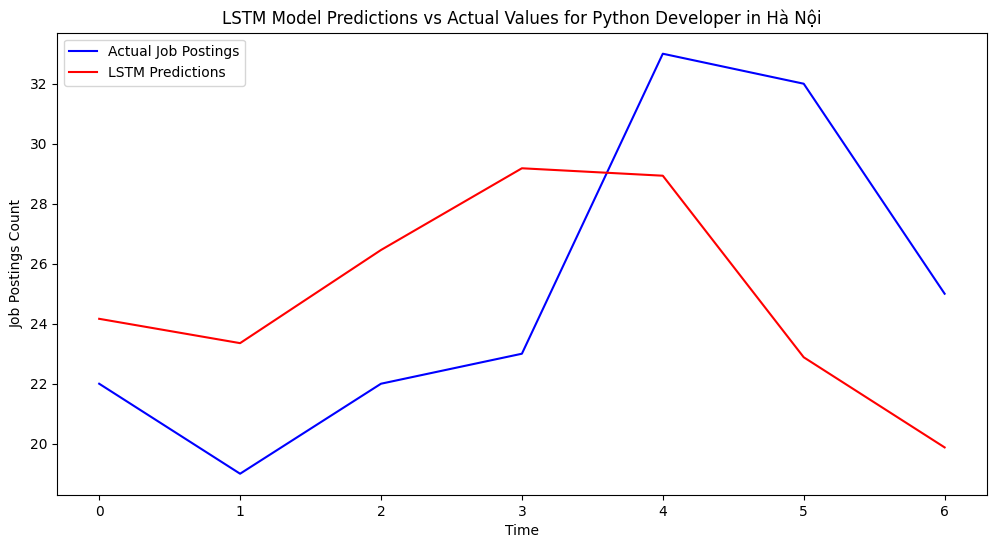

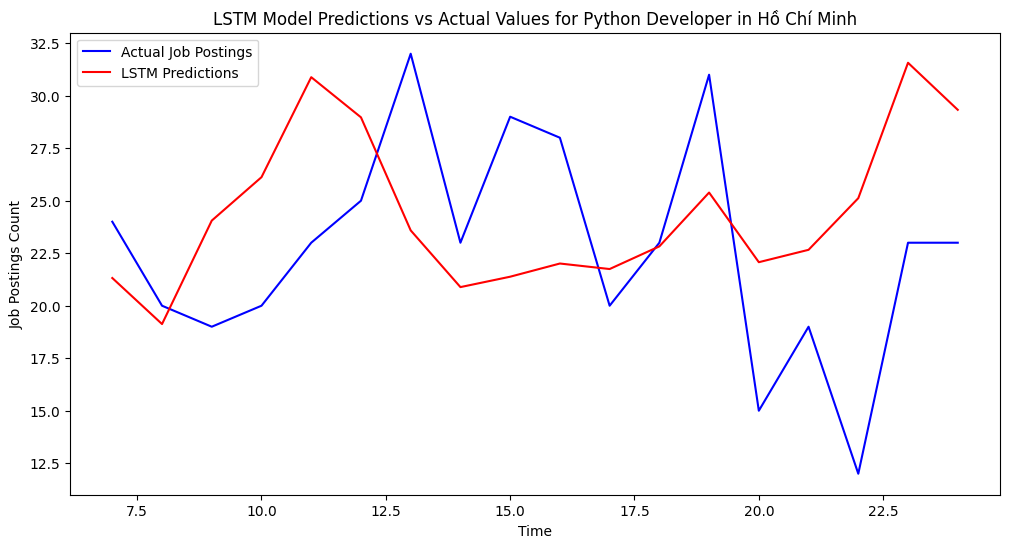

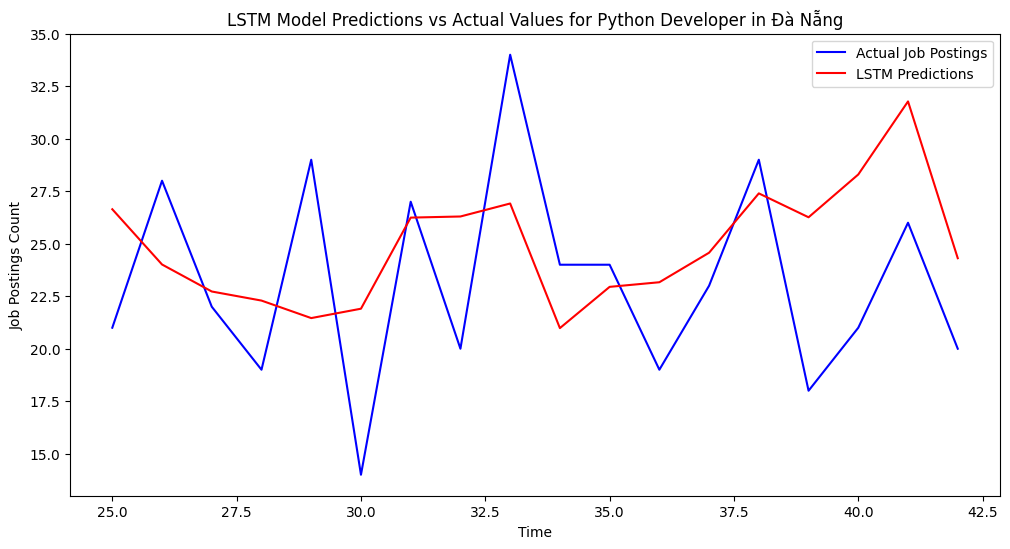

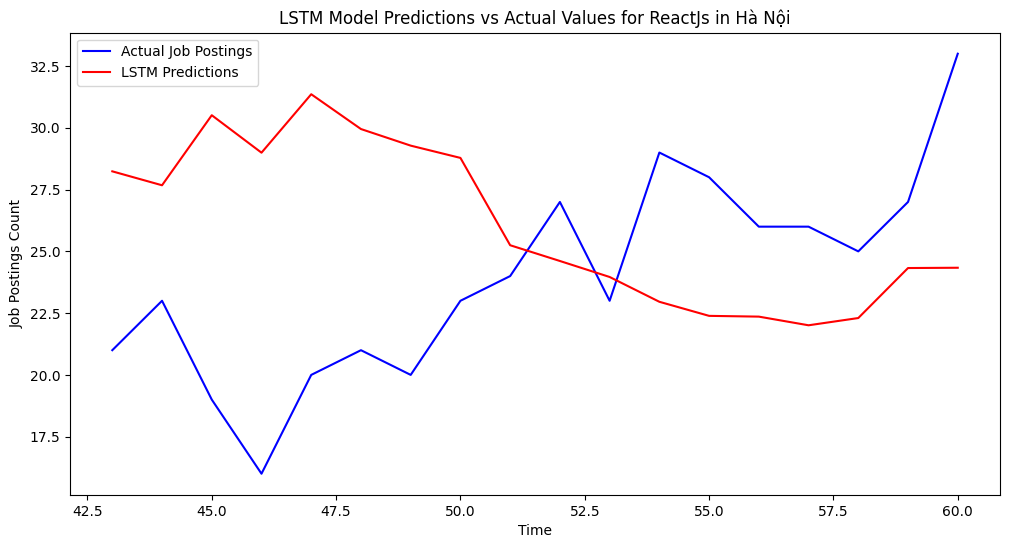

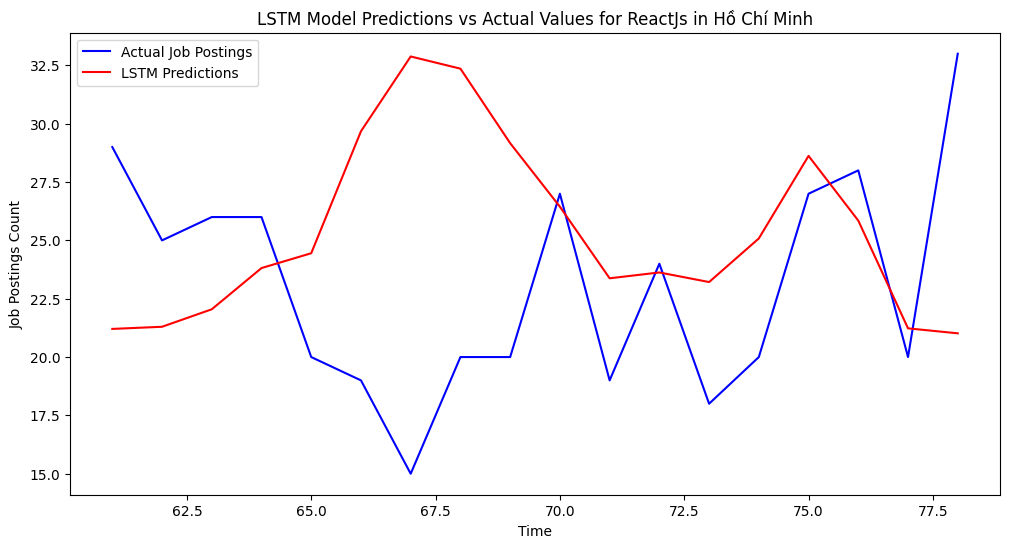

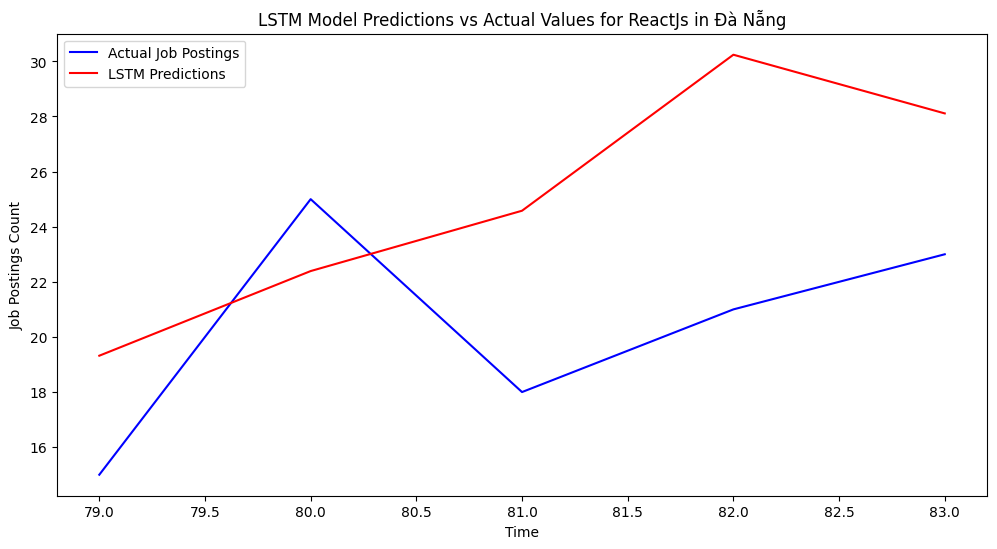

In [ ]:
# Function to plot actual and predicted values for each job and city in the test set
def plot_predictions_for_jobs_and_cities(X_test, y_test_inv, test_predict, job_encoder, city_encoder):
    job_encoded = X_test[:, 0, 0]
    city_encoded = X_test[:, 0, 1]

    # Create a DataFrame for the test data with job and city information
    test_data = pd.DataFrame({
        'job_encoded': job_encoded,
        'city_encoded': city_encoded,
        'actual': y_test_inv.flatten(),
        'predicted': test_predict.flatten()
    })
    test_data['job'] = job_encoder.inverse_transform(test_data['job_encoded'].astype(int))
    test_data['city'] = city_encoder.inverse_transform(test_data['city_encoded'].astype(int))

    unique_jobs = test_data['job'].unique()
    unique_cities = test_data['city'].unique()

    for job in unique_jobs:
        for city in unique_cities:
            job_city_data = test_data[(test_data['job'] == job) & (test_data['city'] == city)]
            if len(job_city_data) > 0:
                plt.figure(figsize=(12, 6))
                plt.plot(job_city_data.index, job_city_data['actual'], label='Actual Job Postings', color='blue')
                plt.plot(job_city_data.index, job_city_data['predicted'], label='LSTM Predictions', color='red')
                plt.xlabel('Time')
                plt.ylabel('Job Postings Count')
                plt.title(f'LSTM Model Predictions vs Actual Values for {job} in {city}')
                plt.legend()
                plt.show()

# Plot predictions for each job and city in the test set
plot_predictions_for_jobs_and_cities(X_test, y_test_inv, test_predict, job_encoder, city_encoder)

In [ ]:
# Predict future job postings for a specific job and city
def predict_future(job, city, time_step=12, future_periods=12):
    job_encoded = job_encoder.transform([job])[0]
    city_encoded = city_encoder.transform([city])[0]
    x_input = aggregated_data[(aggregated_data['job'] == job) & (aggregated_data['city'] == city)]['job_postings_count_scaled'].values[-time_step:]

    # Append job_encoded and city_encoded as features
    x_input = np.array([np.append([job_encoded, city_encoded], x) for x in x_input.reshape(-1, 1)])

    temp_input = x_input.tolist()
    lst_output = []

    for i in range(future_periods):
        if len(temp_input) > time_step:
            x_input = np.array(temp_input[-time_step:])
            x_input = x_input.reshape(1, time_step, len(features))
            yhat = model.predict(x_input, verbose=0)
            next_input = [job_encoded, city_encoded, yhat[0][0]]
            temp_input.append(next_input)
            lst_output.append(yhat[0][0])
        else:
            x_input = np.array(temp_input)
            x_input = x_input.reshape(1, len(temp_input), len(features))
            yhat = model.predict(x_input, verbose=0)
            next_input = [job_encoded, city_encoded, yhat[0][0]]
            temp_input.append(next_input)
            lst_output.append(yhat[0][0])

    # Inverse transform the predictions
    future_predict = scaler.inverse_transform(np.array(lst_output).reshape(-1, 1))
    return future_predict

# Predict future job postings for ReactJs in Hanoi
future_predictions = predict_future('ReactJs', 'Hà Nội', time_step, 6)
print(future_predictions)

[[29.279749]
 [25.855577]
 [21.650969]
 [22.688648]
 [24.732994]
 [24.00322 ]]
